# **Transformer Interpretability**

In this coding homework, you will:
* Implement a single attention head
* Implement an induction copy head by combining a previous token head with a copying head.

In [1]:
#pull the github repo
# !git clone https://github.com/Berkeley-CS182/cs182fa25_public.git

In [2]:
# %cd cs182fa25_public/hw11/code/q_coding_interpretability/

## **Imports & Preliminaries**


In [3]:
from pathlib import Path
from typing import Tuple

import json
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import ArrayLike, NDArray

SEED = 2025
EPS = 1e-6
np.random.seed(SEED)

In [4]:
def plot_weight_heatmap(
    matrix: ArrayLike,
    title: str = "Weight Matrix Heatmap",
    cmap: str = "RdBu_r",
    annotate: bool = True,
    figsize: Tuple[int, int] = (8, 6),
    precision: int = 2,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot the weights of a matrix as a heatmap.

    Args:
        matrix: 2D array-like - The weight matrix to visualize
        title: Title for the plot
        cmap: Colormap to use (default: 'RdBu_r' for diverging red-blue)
        annotate: Whether to show values in each cell
        figsize: Figure size (width, height)
        precision: Number of decimal places for annotations

    Returns:
        Tuple of (fig, ax) - Matplotlib figure and axes objects
    """
    matrix = np.asarray(matrix)

    fig, ax = plt.subplots(figsize=figsize)

    # Create heatmap with symmetric color scale around zero
    vmax = np.abs(matrix).max()
    vmin = -vmax if vmax != 0 else -1

    im = ax.imshow(matrix, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Weight Value')

    # Add annotations if requested and matrix is small enough
    if annotate and matrix.size <= 100:
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                text_color = 'white' if abs(matrix[i, j]) > vmax * 0.5 else 'black'
                ax.text(
                    j, i, f'{matrix[i, j]:.{precision}f}',
                    ha='center', va='center', color=text_color, fontsize=8
                )

    # Labels and title
    ax.set_xlabel('Column Index')
    ax.set_ylabel('Row Index')
    ax.set_title(title)

    # Set tick marks
    ax.set_xticks(np.arange(matrix.shape[1]))
    ax.set_yticks(np.arange(matrix.shape[0]))

    plt.tight_layout()
    plt.show()

    return fig, ax


## **Question 1: A Single Attention Head**
In this question, you'll implement an attention head.

### Specifications:
* The query-key matrices are provided already multiplied together (i.e., we provide as input $W_{QK} = W_Q^\top W_K$, called `WQK`).
* The output-value matrices are provided already multiplied together (i.e., we provide as input $W_{OV} = W_O^\top W_V$, called `WOV`).
* Attention inputs are also provided as a list of `d_model`-length vectors, called `attn_input`. The list elements correspond to positions in the context.
* The desired outputs are the outputs the attention head produces at each position. This should be a list of `d_model`-length vectors of the same length as the input.
* **Causal masking:** When implementing attention, mask out positions that come after the current position by setting their attention scores to negative infinity (e.g., `-1e9`) before applying softmax.
* You should first convert the inputs to numpy arrays as a first step.

### Note:
* You should **not** use `np.softmax` when calculating the attention scores.


In [5]:
def single_attention_head(
    attn_input: ArrayLike,
    WQK: ArrayLike,
    WOV: ArrayLike,
    debug: bool = False,
) -> NDArray[np.floating]:
    """
    Implement a single attention head.

    Args:
        attn_input: Input to attention head, shape (seq_len, d_model)
        WQK: Premultiplied query-key matrix, shape (d_model, d_model)
        WOV: Premultiplied output-value matrix, shape (d_model, d_model)
        debug: If True, plots heatmaps of scores, masked scores, attention weights, and XOV

    Returns:
        numpy.ndarray - Output of attention head, shape (seq_len, d_model)
    """
    # step 0: convert to numpy arrays
    X = np.asarray(attn_input)
    WQK = np.asarray(WQK)
    WOV = np.asarray(WOV)

    seq_len, d_model = X.shape

    # Compute the pre-attention scores by multiplying queries against keys
    scores = X @ WQK @ X.T

    if debug:
        plot_weight_heatmap(scores, title="Scores (Pre-Attention)")

    # Apply a causal mask so tokens cannot attend to later positions
    mask = np.triu(np.full((seq_len, seq_len), -np.inf), k=1)
    masked_scores = scores + mask

    if debug:
        plot_weight_heatmap(masked_scores, title="Scores (After Causal Mask)")

    # Apply softmax across each row
    exp_scores = np.exp(masked_scores)
    attn_weights = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True)

    if debug:
        plot_weight_heatmap(attn_weights, title="Attention Weights (After Softmax)", cmap="Blues")

    # Project values with WOV and combine them with the attention scores
    projected_values = WOV @ X.T

    if debug:
        plot_weight_heatmap(projected_values, title="Projected Values (XOV)")

    out = attn_weights @ projected_values.T

    if debug:
        plot_weight_heatmap(out, title="Output")

    return out


### Test `single_attention_head` basic
For additional debugging, set `debug=True` in the `single_attention_head` call to see the weights of matrices during attention.


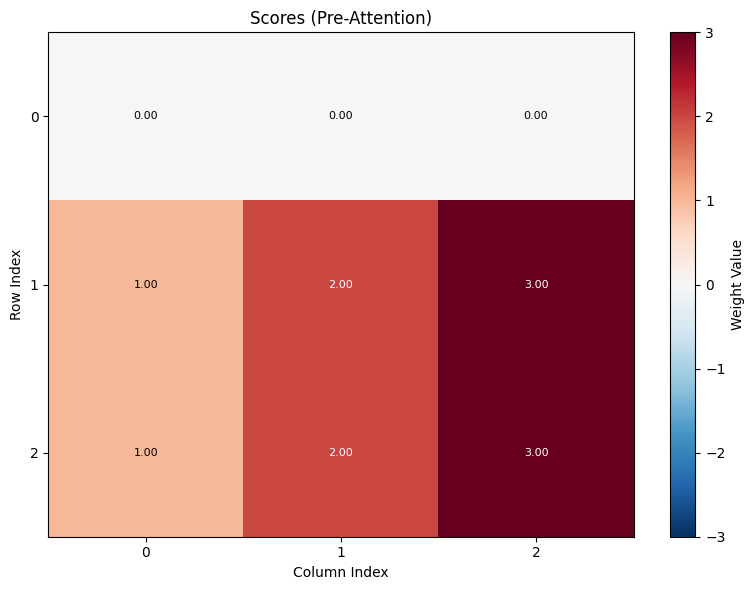

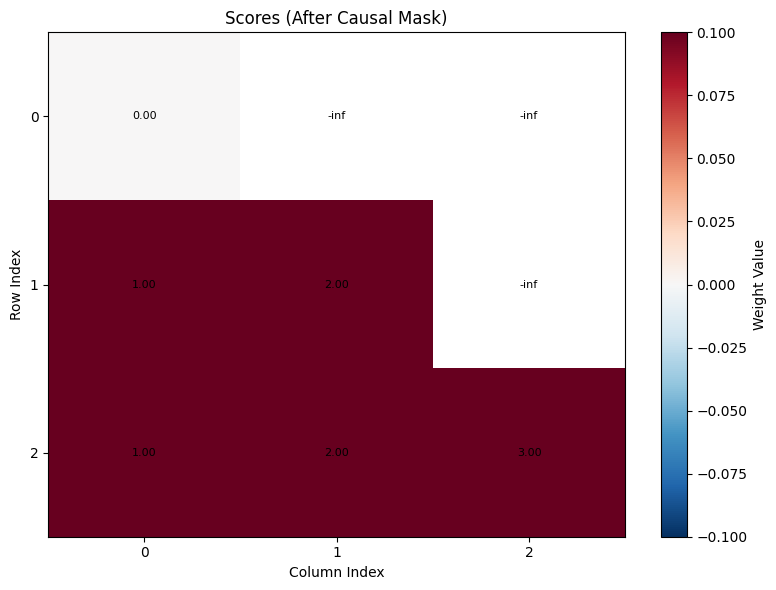

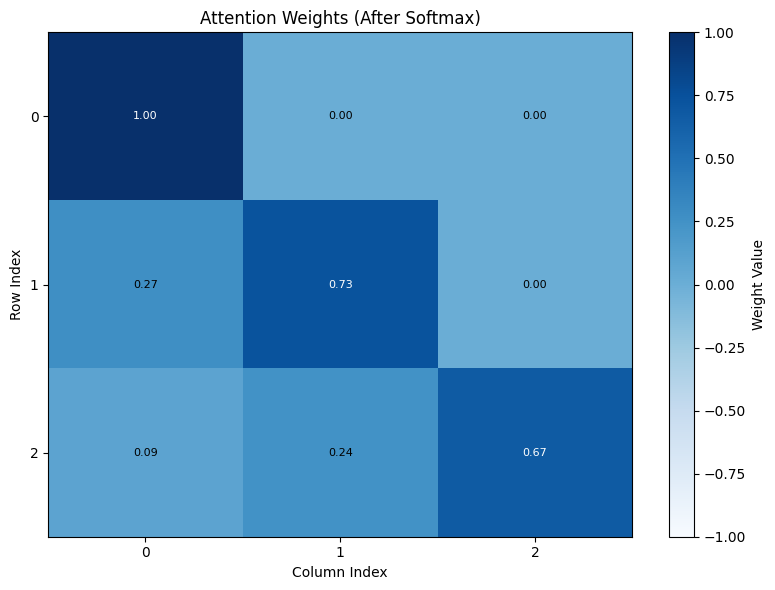

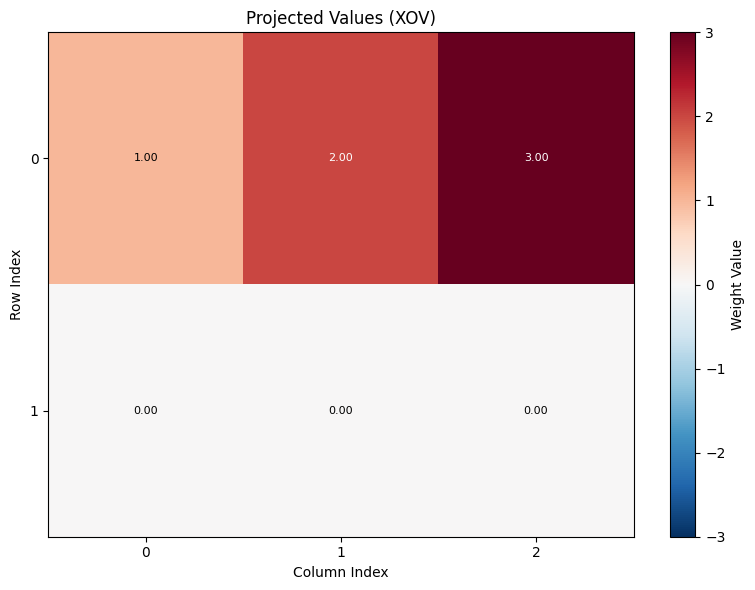

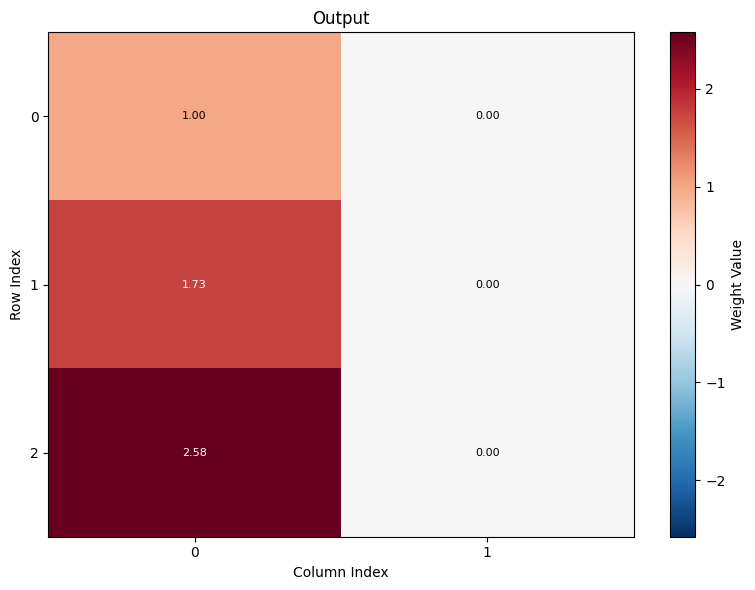

Test case passed ✅


In [6]:
attn_input = [
    [0, 1],
    [1, 1],
    [1, 2],
]
WQK = [
    [1, 1],
    [0, 0],
]
WOV = [
    [1, 1],
    [0, 0],
]

expected_out = [
    [1.0, 0.0],
    [1.7310585786300048, 0.0],
    [2.5752103826044417, 0.0],
]

out = single_attention_head(attn_input, WQK, WOV, debug=True).tolist()

assert np.isclose(expected_out, out, atol=EPS).all(), f"Failed:\nExpected: {expected_out}\nGot: {out}"
print("Test case passed ✅")

### Test `single_attention_head`


In [7]:
with Path('single_attention_head_test_cases.json').open() as f:
    single_attention_head_test_cases = json.load(f)

for test_case_id, (attn_input, WQK, WOV, expected_out) in single_attention_head_test_cases.items():
    out = single_attention_head(attn_input, WQK, WOV).tolist()
    case_num = test_case_id.split()[-1]
    assert np.isclose(expected_out, out, atol=EPS).all(), (
        f"Test Case {case_num} Failed:\nExpected: {expected_out}\nGot: {out}"
    )

print("All test cases passed ✅")

All test cases passed ✅


## **Question 2: An Induction Copy Head**
In this problem, you will combine a previous token head with a copying head.

### Background:
An induction head operates by predicting that previously-seen adjacencies in the sequence will be seen again. That is, it predicts `ab...a` will be followed by `b` (for any `a, b`).

### Specifications:
* #### Vocabulary and Embeddings
  - Vocabulary size: 4
  - Tokens: `a`, `b`, `c`, `d`
  - Maximum sequence length: 5
  - Embedding: 2-hot encoded with `d_model = 9`
    - First 4 dimensions: 1-hot encoding of token vocabulary
    - Next 5 dimensions: 1-hot encoding of position (0-4)
  - The unembeddings are the same as the embeddings. The model produces an output vector of length 4 which encodes the logits on `a,b,c,d` respectively.
* ### Induction Head Mechanism
  - Your implementation should consist of two stages.
     1. **Previous Token Head:** Identifies tokens that are directly adjacent to each other (using position information)
     2. **Induction Head:** Takes the output from the previous token head and copies the token that follows matching patterns.

     Together, these implement the pattern: `a,b,...,a -> b` for all `a, b`.
* ### Previous Token Head
  - Attend from each position to its direct predecessor
  - Extract and pass forward the token identities
  - Use `attention_strength` for the non-zero entries in the QK matrices.
  - Use only 0's and 1's in the OV matrices.
* ### Induction Head
  - Take input from the previous token head summed with the original token embedding. To make life simpler:
     - Exclude the positional embedding from this sum! That is, just sum the non-positional part of the input embedding with the output from the previous token head.
     - Delete from this sum the first token position, since the previous token head does strange things (e.g., if you have an array of `[seq_len, d_model]`, it should become `[seq_len - 1, d_model]`).
  - Copy the token that follows the previous instance of the present token.
  - Use `attention_strength` for the non-zero entries in the QK matrices.
  - Use only 0's and 1's in the OV matrices.

### Output Format:
* Return an array of 4 logits (one for each vocabulary token)
* The output should be the prediction of the induction head on the last token in the sequence. The output should be just the output from that head (**not** the sum of residual stream with the head's output!).

### Important Implementation Notes
* **Causal masking:** When implementing attention, mask out positions that come after the current position by setting their attention scores to negative infinity (e.g., `-1e9`) before applying softmax.
* **Matrix construction:** Use `attention_strength` for non-zero entries in QK matrices, and use `1.0` for non-zero entries in OV matrices (not `attention_strength`).


### Example
For the sequence `[a, b, c, d, a]`, the prediction should upweight `b`.

#### Step-by-step for this example:
**Previous Token Head** creates outputs where position $i$ contains information about the token at $i - 1$.

After deleting position 0 and adding to token embeddings (without position info), we have representations that know both "what token is here" and "what token came before"

**Induction Head** at the final position sees token `a` and looks for where else `a` appeared with its predecessor information

It finds that position 0 had token `a` (with no predecessor)

It copies what came after position 0, which is token `b`

The output logits should thus have the highest value for token `b`

### Note:
* You should your use your previously implemented function `single_attention_head` for this problem.

### Hints
- Build the previous token head and the copy head separately; test each intermediate tensor to sanity-check shapes.
- Use the positional slots (dims 4-8) to aim queries at the previous position, and the token slots (dims 0-3) to copy token identities.
- When adding the residual stream, drop position 0 so the induction head only sees valid previous-token pairs.


In [8]:
def induction_copy_head(
    embeddings: ArrayLike,
    attention_strength: float,
    debug: bool = False,
) -> NDArray[np.floating]:
    """
    Implement an induction head mechanism combining a previous token head with a copy head.

    Args:
        embeddings: Array of 2-hot encoding embeddings (token + position)
        attention_strength: Attention strength multiplier
        debug: If True, plots heatmaps of intermediate matrices

    Returns:
        Logits for the next token prediction (size 4)
    """
    # Convert to numpy array and unpack dimensions
    X = np.asarray(embeddings)
    seq_len, d_model = X.shape
    vocab_size = 4

    # Build the previous-token head matrices
    WQK_prev = np.zeros((d_model, d_model))
    WOV_prev = np.zeros((d_model, d_model))
    WQK_prev[vocab_size + 1:vocab_size + seq_len, vocab_size:vocab_size + seq_len - 1] = (
        attention_strength * np.eye(seq_len - 1)
    )
    WOV_prev[vocab_size:2 * vocab_size, :vocab_size] = np.eye(vocab_size)

    if debug:
        plot_weight_heatmap(WQK_prev, title="WQK_prev (Projected Queries)")
        plot_weight_heatmap(WOV_prev, title="WOV_prev (Projected Values)")

    # Run the previous-token head (you already wrote `single_attention_head`!)
    prev_out = single_attention_head(X, WQK_prev, WOV_prev)

    if debug:
        plot_weight_heatmap(prev_out, title="prev_out (Previous Token Head Output)", precision=6)

    # Add the residual stream's token information and drop position 0
    prev_out[:seq_len, :vocab_size] += X[:seq_len, :vocab_size]
    prev_out = prev_out[1:, :]

    if debug:
        plot_weight_heatmap(prev_out, title="prev_out (With Residual Stream)")

    # Build the copying head matrices
    WQK_copy = np.zeros((d_model, d_model))
    WOV_copy = np.zeros((d_model, d_model))
    WQK_copy[:vocab_size, vocab_size:2 * vocab_size] = attention_strength * np.eye(vocab_size)
    WOV_copy[:vocab_size, :vocab_size] = np.eye(vocab_size)

    if debug:
        plot_weight_heatmap(WQK_copy, title="WQK_copy (Projected Queries)")
        plot_weight_heatmap(WOV_copy, title="WOV_copy (Projected Values)")

    # Run the copy head and read out logits for the last token
    copy_out = single_attention_head(prev_out, WQK_copy, WOV_copy)
    out = copy_out[-1, :vocab_size]

    if debug:
        plot_weight_heatmap(copy_out, title="Copy Head Output", precision=6)

    return out


### Test `induction_copy_head` basic
For additional debugging, set `debug=True` in the `induction_copy_head` call to see the weights of matrices during attention.

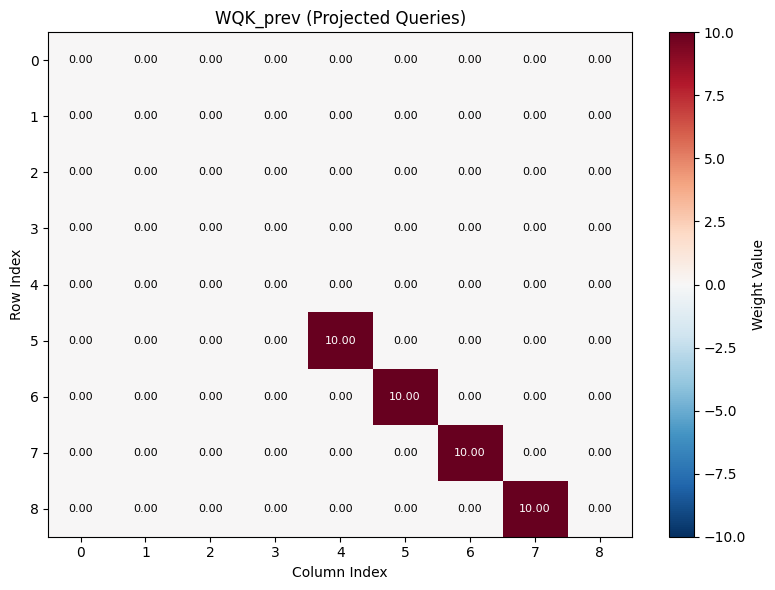

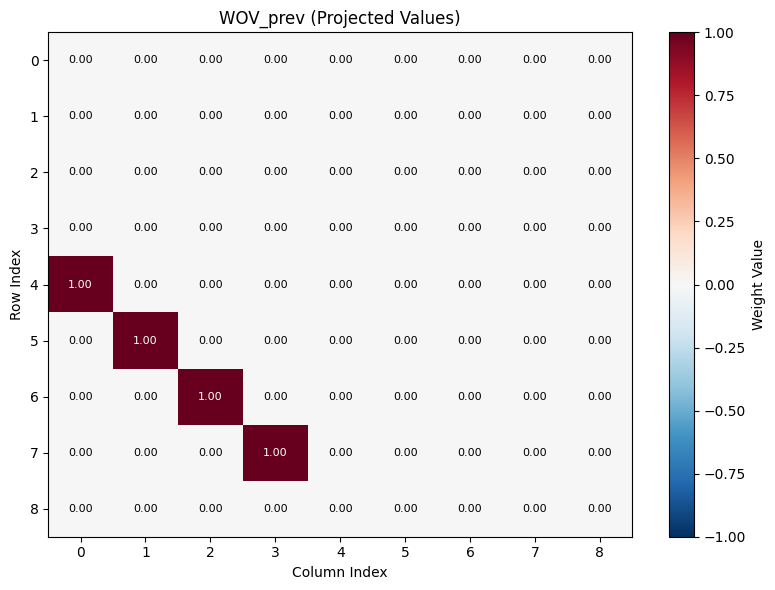

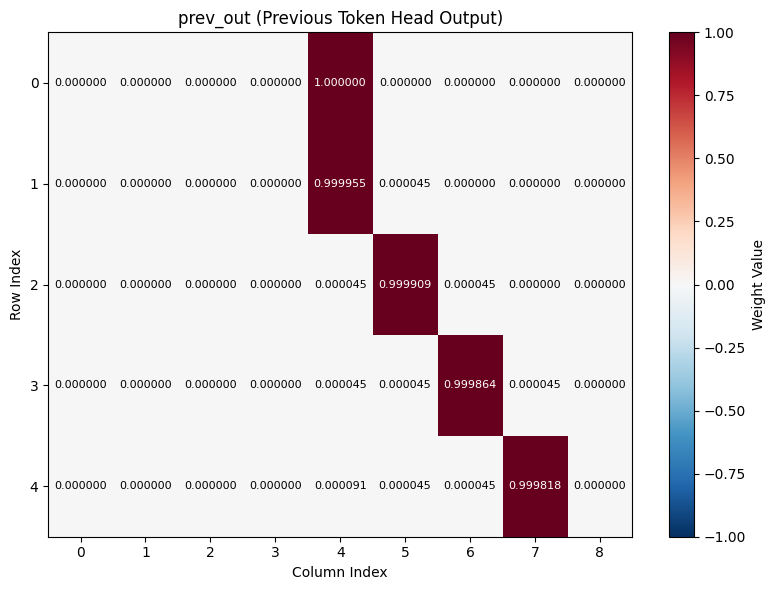

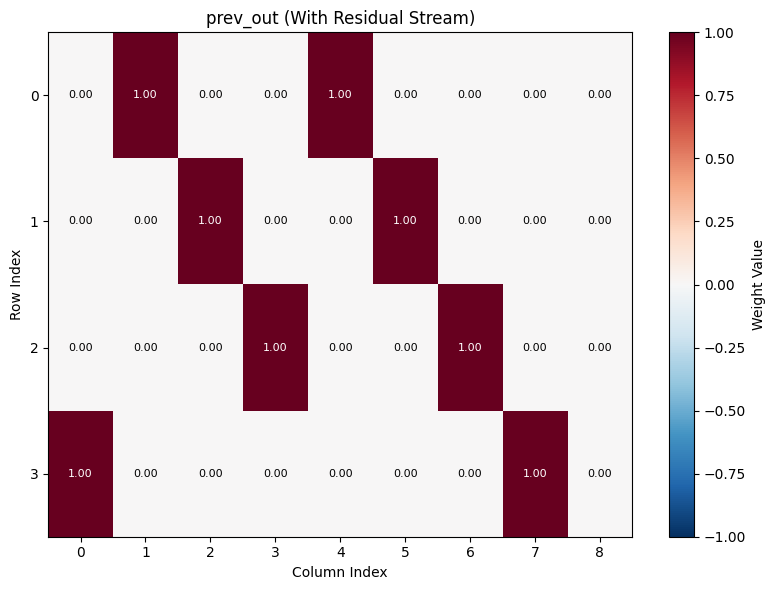

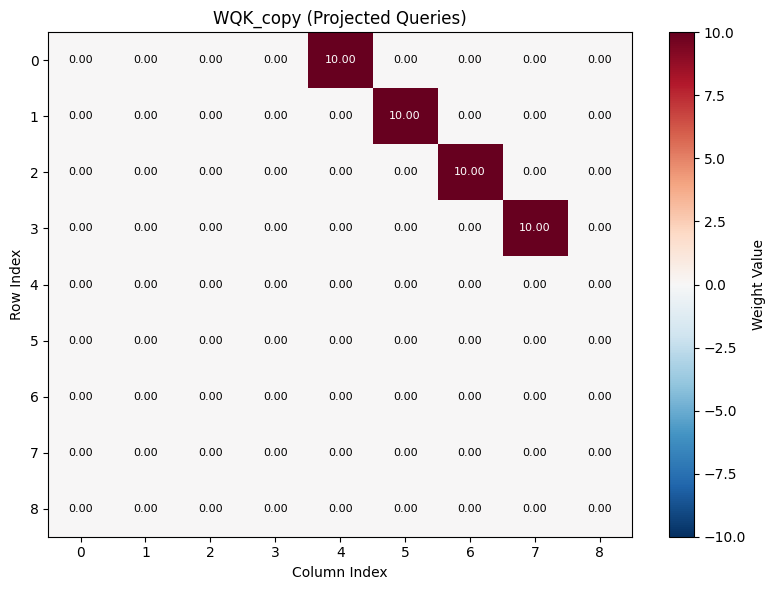

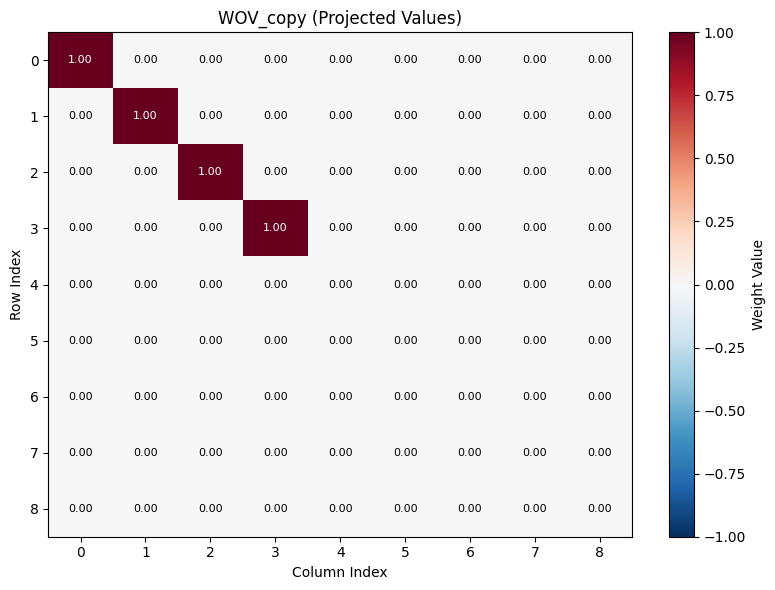

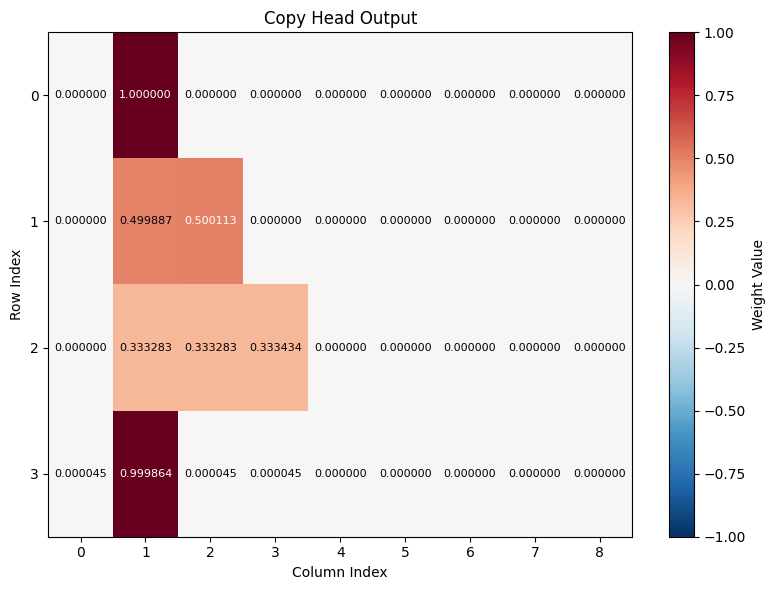

Test case passed ✅


In [9]:
embeddings = [
    [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
]
attention_strength = 10.0

out = induction_copy_head(embeddings, attention_strength, debug=True).tolist()

expected_out = [0.000045, 0.999864, 0.000045, 0.000045]

assert np.isclose(expected_out, out, atol=EPS).all(), f"Failed:\nExpected: {expected_out}\nGot: {out}"
print("Test case passed ✅")

### Test `induction_copy_head`

In [10]:
with Path('induction_head_test_cases.json').open() as f:
    induction_head_test_cases = json.load(f)

for test_case_id, (embeddings, attention_strength, expected_out) in induction_head_test_cases.items():
    out = induction_copy_head(embeddings, attention_strength).tolist()
    case_num = test_case_id.split()[-1]
    assert np.isclose(expected_out, out, atol=EPS).all(), (
        f"Test Case {case_num} Failed:\nExpected: {expected_out}\nGot: {out}"
    )

print("All test cases passed ✅")

All test cases passed ✅
